# 2022.10.30
**Experimenting around MultConv vs. MultParConv**
- Vec() : from np.reshape() --> definition in the reference.

# Torch vs. MultConv vs. MultParConv

In [2]:
%load_ext autoreload
%autoreload
from hlee_utils import *
from hlee_notClass_multiplexed_lee22e import *
from hlee_notClass_multiplexed_lee22e_par import *
from icecream import ic

In [ ]:
#############################
#  Edit here                #
#############################
hi,wi,ci,ki,ti = 32,32, 3, 1, 3
ho,wo,co,ko,to = 32,32, 4, 1, 4
line = 200*np.ones([hi,2])
#############################
#  Do Not Edit              #
#############################
pi,ins,po,outs = get_dims(hi,wi,ci,ki,ti,ho,wo,co,ko,to)
nslots = 2**15
fh,fw = 3,3
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog',      'frog',       'horse','ship','truck']

# 1. 입력 이미지  size=32x32

- 이미지 크기 32x32 #channels=3 (첫번째 채널만 이미지데이터, 나머지 채널은 0)


ic| ci: 3




+++++++++++++++++++++++++++++++++++++++++++++++++++ IMAGE ch=0 remains (others filled with zeros).


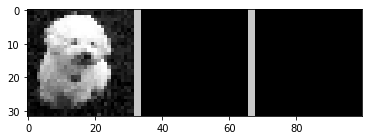

In [8]:
#U=create_U_select(fh,fw,ci,co,"dummy")
#u = get_channel_first(U)
img = create_img_single(ins)
a =get_channel_first(img)
hstack=a[0]
for i in range(1,ci):
    hstack = np.hstack([hstack,line,a[i]])
print("\n\n+++++++++++++++++++++++++++++++++++++++++++++++++++ IMAGE ch=0 remains (others filled with zeros).")
plt.imshow(hstack,cmap='gray')

# 2. Torch Conv (ci=3, co=4) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
channel out : 4
channel out : 4
[cnn] U_multconv  : (3, 3, 3, 4)
[cnn] U_torchconv : torch.Size([4, 3, 3, 3])


+++++++++++++++++++++++++++++++++++++++++++++++++++ TORCH out (CHANNEL :0>1>2>3)


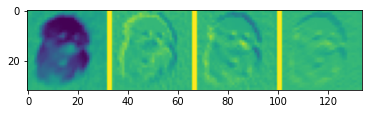

In [9]:
%load_ext autoreload
%autoreload
from hlee_cnn import *
tor = TorchConv_infer(len(classes),ho,wo,co,F.relu,fn_param="./models/simple_model_hlee.pt",device='cpu')
torout = tor.TorchConv_single(img)
U_torchconv = tor.U_torchconv #with channel last.
U  = tor.U_multconv #with channel last.
hs_tor = torout[0]
for i in range(1,co):
    hs_tor=np.hstack([hs_tor,line,torout[i]])
plt.imshow(hs_tor)
print("\n\n+++++++++++++++++++++++++++++++++++++++++++++++++++ TORCH out (CHANNEL :0>1>2>3)")

# 3. MultConv

[MultConv] (hi,wi,ci) =(32,32,3),(ho,wo,co)=(32,32,4),(fh,fw)=(3,3)
[MultConv] (ki,ti) =(1,3), (ko,to) =(1,4)


+++++++++++++++++++++++++++++++++++++++++++++++++++ MultConv out (CHANNEL :0>1>2>3)


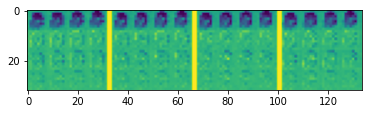

In [10]:
ct_a = MultPack(img,ins,nslots)
out = MultConv(ct_a,U,ins,outs)
un = unpack(out,outs)
hs = un[0]
for i in range(1,co):
    hs=np.hstack([hs,line,un[i]])
print("\n\n+++++++++++++++++++++++++++++++++++++++++++++++++++ MultConv out (CHANNEL :0>1>2>3)")
plt.imshow(hs)
#plt.imshow(un[1])

# 4. MultParConv

[MultParConv] (hi,wi,ci,ki,ti,pi) =(32,32, 3, 1, 3, 8.0)
[MultParConv] (ho,wo,co,ko,to,po) =(32,32, 4, 1, 4, 8.0)
[MultParConv] q = 1.0


+++++++++++++++++++++++++++++++++++++++++++++++++++ MultParConv out (CHANNEL :0>1>2>3)


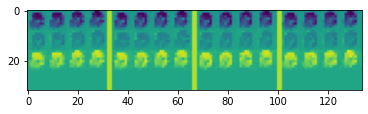

In [11]:
ct_a_par = MultParPack(img,ins)
out_par = MultParConv(ct_a_par,U,ins,outs)
un_par = unpack(out_par,outs)
hs_par = un_par[0]
for i in range(1,co):
    hs_par=np.hstack([hs_par,line,un_par[i]])
print("\n\n+++++++++++++++++++++++++++++++++++++++++++++++++++ MultParConv out (CHANNEL :0>1>2>3)")
plt.imshow(hs_par)
#plt.imshow(un_par[0])